### 0. Before running this notebook, run the script `download_ice_data.py`

In [1]:
import pandas as pd
import rasterio
from pathlib import Path
import geopandas
import numpy as np
import matplotlib.pyplot as plt
if not Path("figures").exists():
    Path("figures").mkdir()

### 1. Read in coordinates of sites to analyse

In [2]:
sites = pd.read_csv("NBP1902MC-cores.csv")

### 2. Extract pixel value from sea ice tifs at each site

In [3]:
# List directories that contain imagery
dirs = list(Path("satellite_images").glob("*"))
df = pd.DataFrame()
for image_dir in dirs:
    # Open one tif at a time. Each one is the composite of a UTC day
    for tif_num, file in enumerate(image_dir.glob("*.tif")):
        fn = str(file)
        # Read in tif with rasterio
        tif = rasterio.open(fn)
        data = tif.read()[0, :, :]
        # Create geopandas dataframe with coordiates of sites
        gdf = geopandas.geodataframe.GeoDataFrame(sites, geometry=geopandas.points_from_xy(sites.X, sites.Y, crs="EPSG:4326"))
        # Project lon-lat coordinates into the crs of the tif. In this case crs=3976 WGS 84 / NSIDC Sea Ice Polar Stereographic South https://epsg.io/3976
        gdf = gdf.to_crs(tif.crs)
        row_dict = {}
        row_dict["date"] = fn.split("/")[-1].split(".")[0]
        # Loop over the dataframe taking one site at a time
        with rasterio.open(fn) as src:
            for i, df_row in gdf.iterrows():
                # Find the pixel that covers this site
                geom = df_row["geometry"]
                row, col = rasterio.transform.rowcol(src.transform, geom.x, geom.y)
                # Add the pixel value to the dictionary
                pixel_value =  data[row, col]
                row_dict[df_row.Name] = pixel_value
        # Add pixel values for all sites from this data to the dataframe
        df = pd.concat((df, pd.DataFrame(row_dict,index = [tif_num], )))
df = df.sort_values(by="date")
df = df.set_index("date")

### 3. Convert the pixel values to sea ice percentage
from https://seaice.uni-bremen.de/data-archive/: 

Ice concentrations are scaled between 0 and 100, land and missing values are set to 120 (older files: SIC: 0-200, land/NaN: 255)

Our tifs have values ranging from 0 to 200 with some values of 255

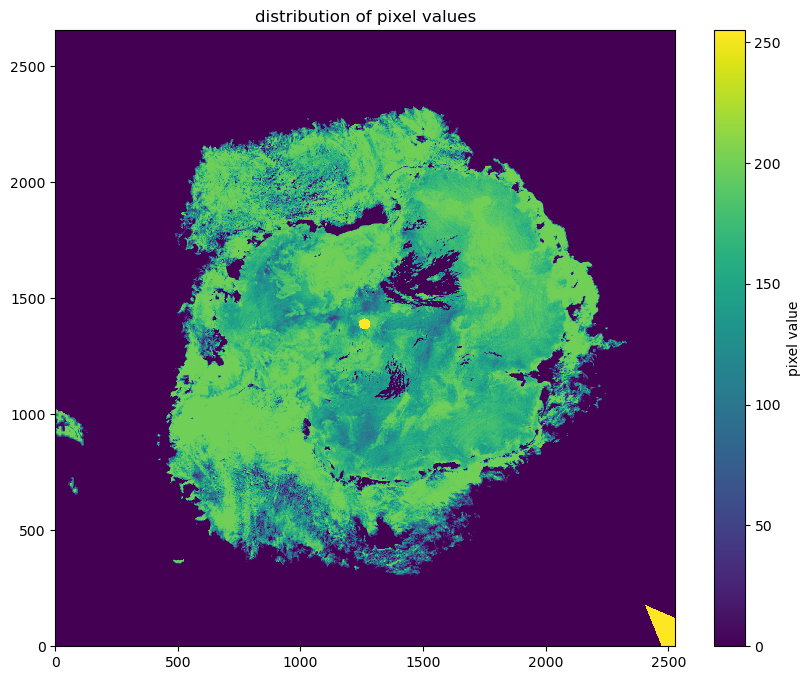

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
pixels = ax.pcolor(data)
ax.set_title("distribution of pixel values")
plt.colorbar(pixels, label="pixel value")
plt.savefig("figures/example_pixel_values_map.png")

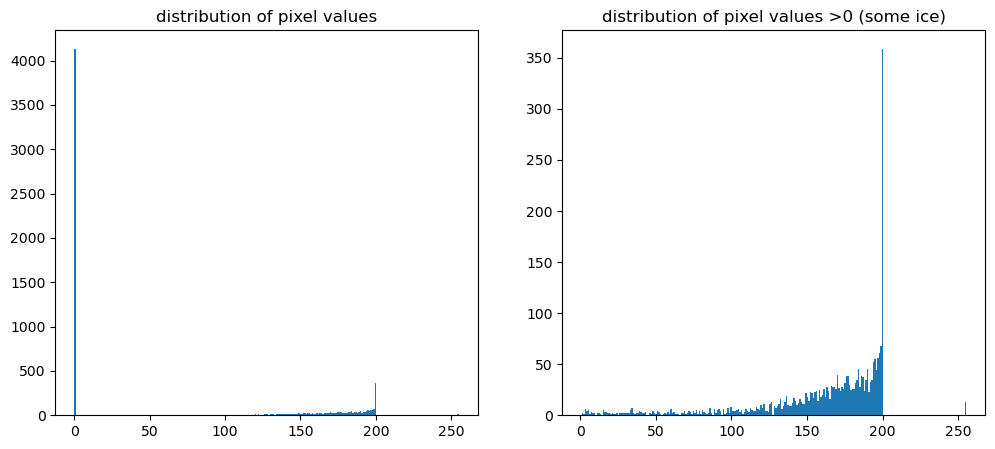

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].hist(data.flatten()[::1000], 256);
ax[1].hist(data.flatten()[::1000][data.flatten()[::1000]>0], 256);
ax[0].set_title("distribution of pixel values")
ax[1].set_title("distribution of pixel values >0 (some ice)")
plt.savefig("figures/example_pixel_values_histogram.png")

In these pixel value plots, 0 represents fully open water, 200 is fully ice and 255 is land mask/invalid

We set mask values to np.nan and divide all other values by 2, such that the range 0-200 becomes range 0-100 for percentage sea ice cover

In [6]:
df[df==255] = np.nan
df_percent_cover = df / 2

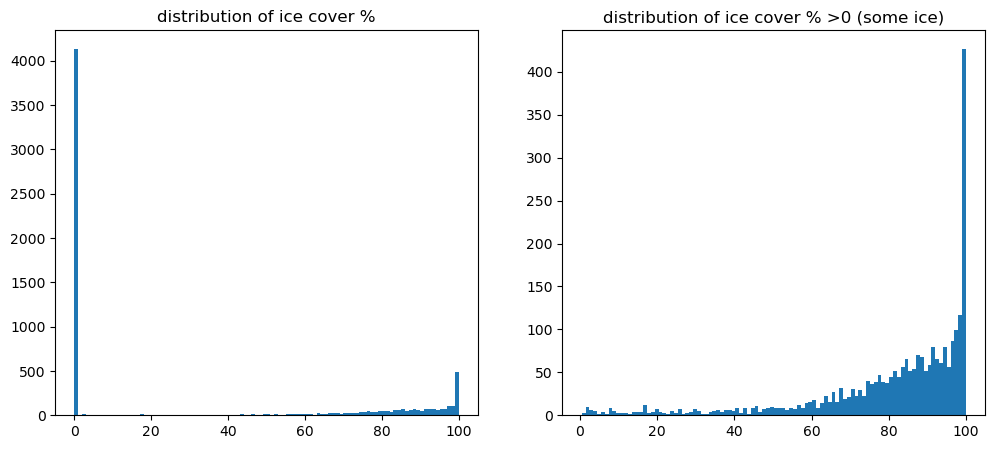

In [7]:
data_percent = data.flatten()[::1000].astype(float)
data_percent[data_percent==255] = np.nan
data_percent = data_percent / 2

fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].hist(data_percent, 100);
ax[1].hist(data_percent[data_percent>0], 100);
ax[0].set_title("distribution of ice cover %")
ax[1].set_title("distribution of ice cover % >0 (some ice)")
plt.savefig("figures/example_ice_cover_percentage_histogram.png")

In [8]:
df_percent_cover

,MC 06,MC 09,MC 16,MC 22,MC 26,BC 28
date,,,,,,
2014-12-01,85.5,96.0,91.5,98.5,0.0,11.5
2014-12-02,90.5,95.5,92.5,96.5,0.0,1.5
2014-12-03,94.0,97.5,95.5,97.5,0.0,52.0
2014-12-04,93.5,99.5,94.0,98.0,0.0,35.5
2014-12-05,92.5,96.0,96.0,99.0,0.0,16.5
...,...,...,...,...,...,...
2019-02-25,48.5,0.0,0.0,92.0,44.0,0.0
2019-02-26,55.5,0.0,14.5,77.0,0.0,6.5
2019-02-27,58.0,6.5,2.5,85.0,26.0,0.0


In [9]:
print("mean ice cover %")
df_percent_cover.mean()

mean ice cover %


MC 06    95.382418
MC 09    91.139560
MC 16    78.509890
MC 22    93.970330
MC 26    37.412088
BC 28    40.006593
dtype: float64

### 4. Class each values as ice or open water
Setting a threshold of 50 %. Values <= to 50 % ice coverage are classed as open water. Those > 50 % are classed as ice

In [10]:
threshold = 50
df_classify = df_percent_cover.copy()
df_classify[df_percent_cover>threshold] = 0
df_classify[df_percent_cover<=threshold] = 1

In [11]:
df_classify

,MC 06,MC 09,MC 16,MC 22,MC 26,BC 28
date,,,,,,
2014-12-01,0.0,0.0,0.0,0.0,1.0,1.0
2014-12-02,0.0,0.0,0.0,0.0,1.0,1.0
2014-12-03,0.0,0.0,0.0,0.0,1.0,0.0
2014-12-04,0.0,0.0,0.0,0.0,1.0,1.0
2014-12-05,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...
2019-02-25,1.0,1.0,1.0,0.0,1.0,1.0
2019-02-26,0.0,1.0,1.0,0.0,1.0,1.0
2019-02-27,0.0,1.0,1.0,0.0,1.0,1.0


In [12]:
print("proportion of days classified as clear water")
df_classify.mean()

proportion of days classified as clear water


MC 06    0.013187
MC 09    0.079121
MC 16    0.210989
MC 22    0.028571
MC 26    0.635165
BC 28    0.584615
dtype: float64

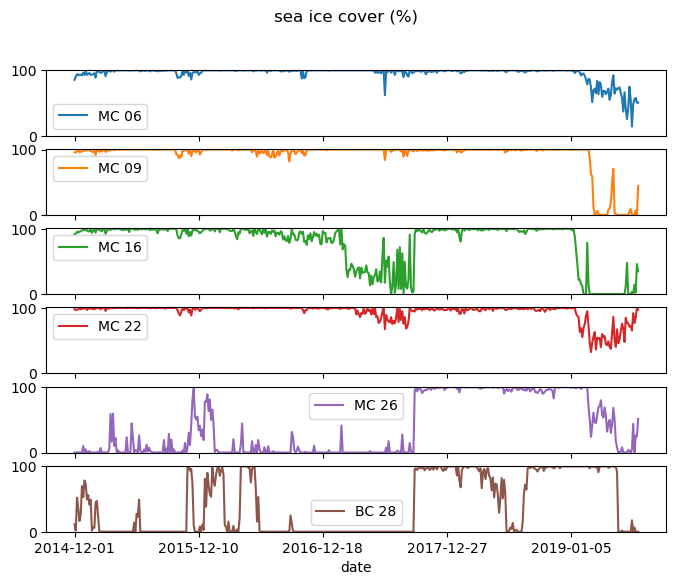

In [13]:
fig = df_percent_cover.plot(subplots=True, figsize=(8, 6), ylim=(0, 101),title="sea ice cover (%)");
plt.savefig("figures/sea_ice_cover.png")

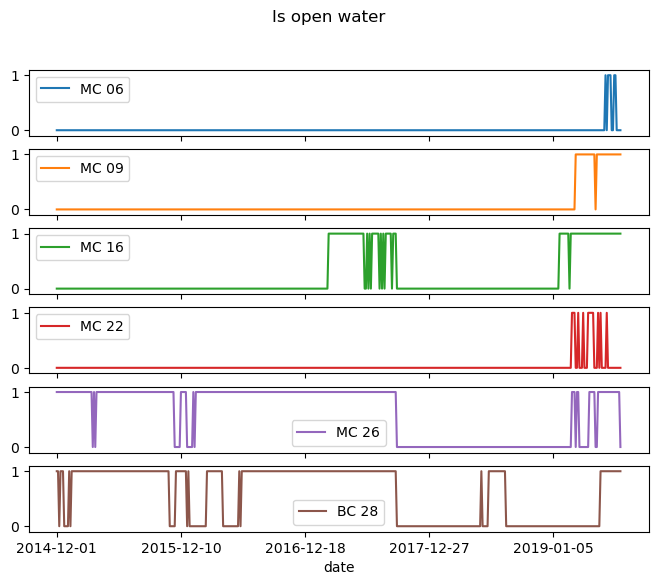

In [14]:
df_classify.plot(subplots=True, figsize=(8, 6), ylim=(-0.1, 1.1),title="Is open water");
plt.savefig("figures/open_water.png")